In [11]:
import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops.relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

In [12]:
import os 
import sys

_libpath = os.path.expanduser('../')
_slimpath = os.path.join(_libpath,'slim')
sys.path.insert(0,_slimpath)
sys.path.insert(0,_libpath)

In [13]:
import tensorflow.contrib.slim as slim
from nets import vgg

In [37]:
eval_graph = tf.Graph()
with eval_graph.as_default():
    with eval_graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        
        with slim.arg_scope(vgg.vgg_arg_scope()):
                
                x = tf.placeholder(tf.float32, [1, 224, 224, 3])
                y = tf.placeholder(tf.float32, [1, 1000])#
    
                is_train = tf.placeholder(tf.bool)
                net, end_points = vgg.vgg_16(x, 1000, is_training=is_train)#
                # print end_points.keys() # print keys
                logit = end_points['vgg_16/fc8'] # before softmax
                prob = tf.nn.softmax(end_points['vgg_16/fc8'], name='prob')
#                 prob  = end_points['predictions'] # after softmax
                conv  = end_points['vgg_16/pool5']
                cost  = tf.reduce_sum((logit * y))
                conv_grad = tf.gradients(cost, conv)[0]
                conv_grad_norm = tf.div(conv_grad,
                                       tf.sqrt(tf.reduce_mean(tf.square(conv_grad)))
                                        +tf.constant(1e-10))
                ginit = tf.global_variables_initializer()
                linit = tf.local_variables_initializer()
                """ Restorer """
                ckpt = 'model/vgg_16.ckpt'
                variables_to_restore = slim.get_variables_to_restore(include=["vgg_16"])
                saver = tf.train.Saver(variables_to_restore)
print ("Graph ready")

Graph ready


In [38]:
""" Open session """
_config = tf.ConfigProto(); 
_config.gpu_options.allow_growth=True
sess = tf.Session(graph=eval_graph,config=_config)
""" Restore """
sess.run(ginit)
# sess.run(linit)
saver.restore(sess, ckpt)

INFO:tensorflow:Restoring parameters from model/vgg_16.ckpt


In [39]:
import os, urllib, tarfile, cv2, skimage, skimage.io, time
from matplotlib import pyplot as plt
from skimage.transform import resize
import numpy as np
import utils

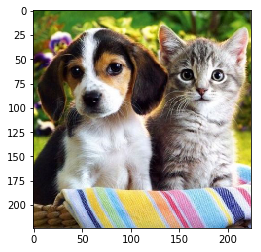

[0][0.247] beagle
[1][0.149] Egyptian cat
[2][0.067] tiger cat
[3][0.052] tabby, tabby cat
[4][0.032] Brittany spaniel


In [40]:
""" Load image """
img = skimage.io.imread("./dog-kitten.jpg")
# img = skimage.io.imread("./t/0/0022_2.jpg")
short_edge = min(img.shape[:2])
yy = int((img.shape[0] - short_edge) / 2)
xx = int((img.shape[1] - short_edge) / 2)
crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
img_rgb = skimage.transform.resize(crop_img, (224, 224), preserve_range=True)
img_rgb_rshp = img_rgb.reshape((1, 224, 224, 3))
""" Plot """
plt.imshow(img_rgb/255.)
# plt.imshow(img_rgb_rshp)
plt.show()
""" Run graph """
probval = sess.run(prob, feed_dict={x: img_rgb_rshp, is_train: False})
synset = [l.strip() for l in open('./synset.txt').readlines()]
pred = np.argsort(probval.squeeze())[::-1]
# print(probval)

top1 = synset[pred[0]]
top5 = [(synset[pred[i]], probval.squeeze()[pred[i]]) for i in range(5)]
names = []
for idx,t in enumerate(top5):
    names.append(t[0][10:])
    print ("[%d][%.3f] %s" % (idx,t[1],t[0][10:]))

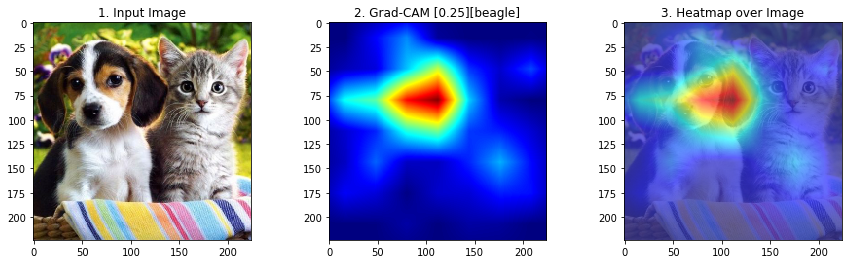

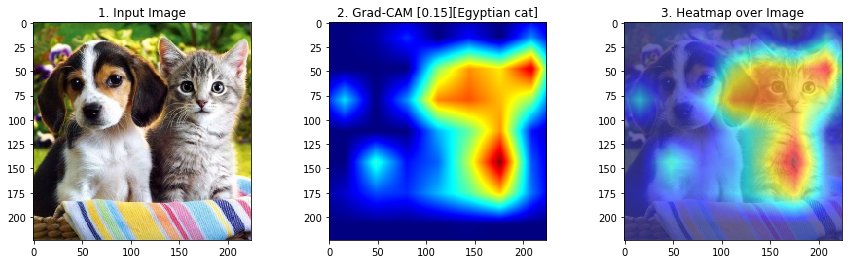

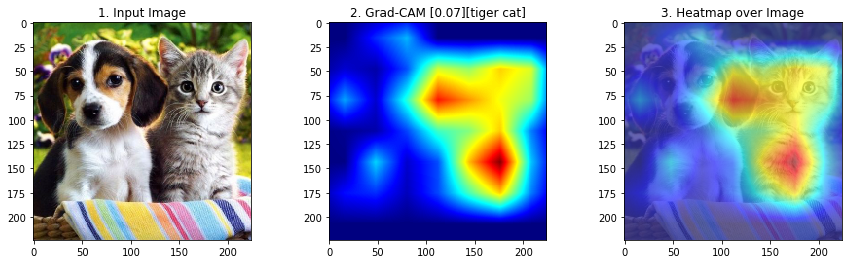

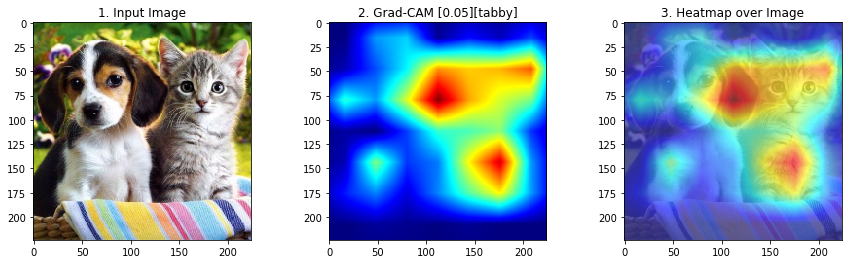

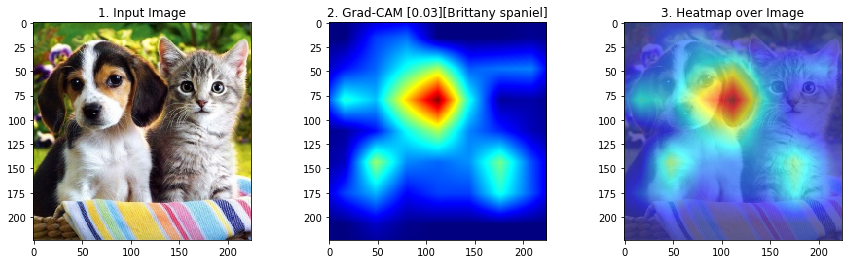

Done.


In [41]:

for idx,pidx in enumerate(pred[:5]):
    target = np.zeros((1,1000))
    target[0,int(pidx)] = 1
    convval,gradval = sess.run([conv,conv_grad_norm],
                              feed_dict={x:img_rgb_rshp,y:target,is_train:True})
    """ Plot """
    output    = convval
    grads_val = gradval
    """ CAM """
    weights   = np.mean(grads_val, axis = (0,1,2)) 			# [512]
    cam       = np.ones(output.shape[1:3], dtype = np.float32)	# [7,7]   
    for i, w in enumerate(weights):
        cam += w * output[0,:,:,i] 
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam) # scale 0 to 1.0    
    cam_rsz = resize(cam, (224,224),preserve_range=True)
    """ Image """
    img = img_rgb_rshp.squeeze().astype(float)    
    img -= np.min(img)
    img /= img.max()
    """ Heatmap """
    cam_heatmap = cv2.applyColorMap(np.uint8(255*cam_rsz), cv2.COLORMAP_JET)
    cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
    """ Plot """
    fig = plt.figure(figsize=(15, 4))    
    ax = fig.add_subplot(131)
    plt.imshow(img)
    ax.set_title('1. Input Image')
    ax = fig.add_subplot(132)
    plt.imshow(cam_heatmap)
    ax.set_title('2. Grad-CAM [%.2f][%s]'%(top5[idx][1],names[idx].split(',')[0]))
    ax = fig.add_subplot(133)
    plt.imshow(img, alpha=.6)
    plt.imshow(cam_heatmap, alpha=.6)
    ax.set_title('3. Heatmap over Image')
    plt.show()
    time.sleep(1)
print ("Done.")